### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
#%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
35 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 42 flags
Removed 42 flags from df
df sorted by tus
2020-12-27 15:14:06.853667
first tus:  -469628.27777777775 | max tus:  1539352.3055555555
5611
tus array OK ...


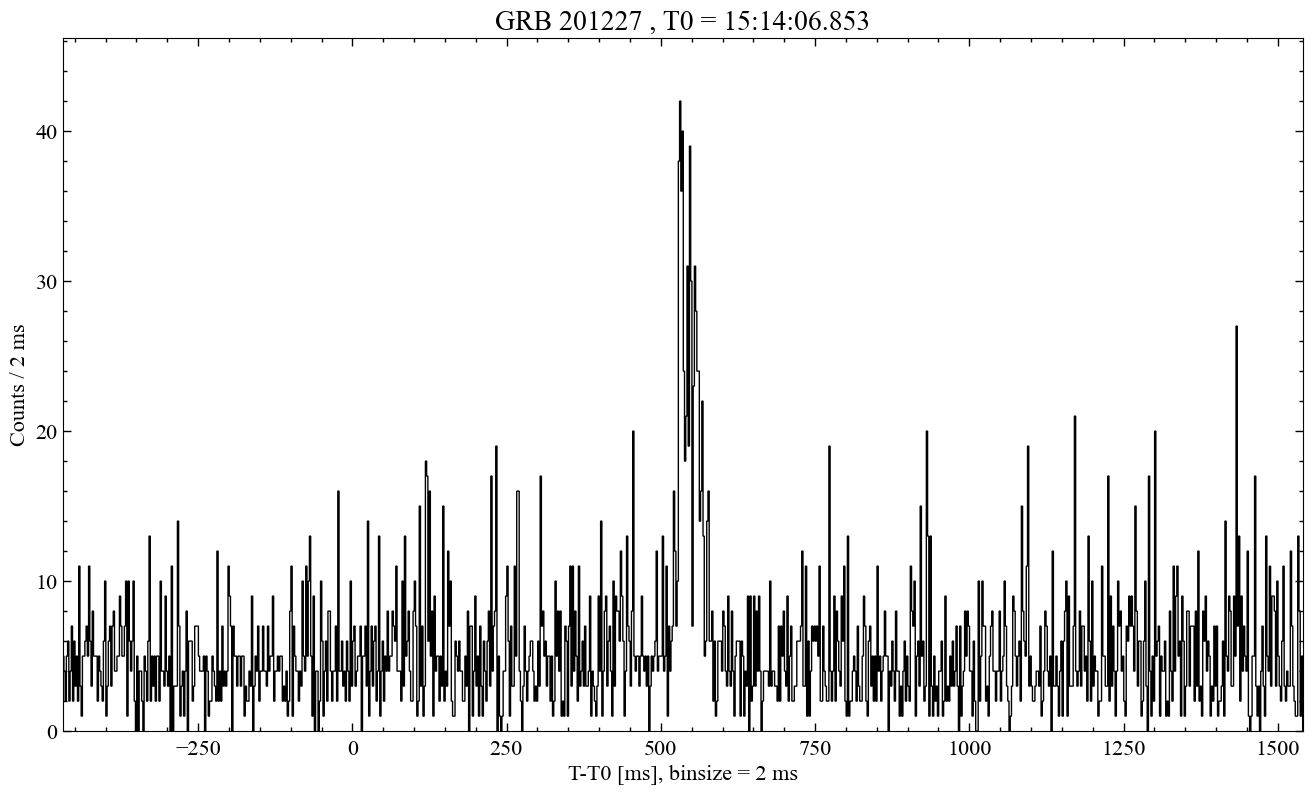

In [2]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB201227",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW

0.512


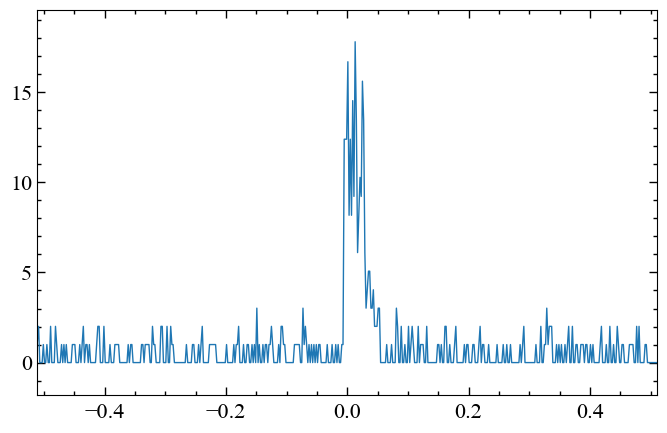

In [3]:
kw_filename = "GRB201227A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002
kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# CrossCorr debugg

## Filter tus arr by keV [350-1500]

In [4]:
laggs = np.arange(-0.55,-0.5,0.001)
tlaggs = []
for laggApprox in laggs:
    
    kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
    tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
    indexInBound = []
    for i,kev in enumerate(kevArr):
        if 350<=kev<=1500:
            indexInBound.append(i)
    kevArr = kevArr[indexInBound]
    tus = tus[indexInBound]
    
    #laggApprox = -0.54
    
    tus += laggApprox
    #TODO: change bins to match the pattern from kw
    asim_bins = np.round(np.arange(-1,1,0.002,dtype=np.float32),3)
    hist = plt.hist(tus,bins=asim_bins,align="left",histtype="step")
    asimCounts,asimEdges = hist[0],hist[1]
    asimLC = LC(time=asimEdges[:-1] + binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)
    kwCompare,asimCompare = CompareLC(kw_lc=kw_lc,asimShiftLC=asimLC,binsize=binsize)
    CC = CrossCorrelation(kwCompare,asimCompare,mode="full")
    CClagg=CC.time_shift
    tlagg = CClagg + laggApprox
    print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
    tlaggs.append(tlagg)

/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-package

-0.512
Total lagg (s):  -0.534375 | CC lagg:  0.015625
-0.512
Total lagg (s):  -0.533375 | CC lagg:  0.015625
-0.512
Total lagg (s):  -0.534328125 | CC lagg:  0.013671875
-0.512
Total lagg (s):  -0.533328125 | CC lagg:  0.013671875
-0.512
Total lagg (s):  -0.53428125 | CC lagg:  0.01171875
-0.512
Total lagg (s):  -0.53328125 | CC lagg:  0.01171875
-0.512
Total lagg (s):  -0.534234375 | CC lagg:  0.009765625
-0.512
Total lagg (s):  -0.533234375 | CC lagg:  0.009765625
-0.512
Total lagg (s):  -0.5341875 | CC lagg:  0.0078125
-0.512
Total lagg (s):  -0.5331875 | CC lagg:  0.0078125
-0.512
Total lagg (s):  -0.534140625 | CC lagg:  0.005859375
-0.512
Total lagg (s):  -0.533140625 | CC lagg:  0.005859375
-0.512
Total lagg (s):  -0.53409375 | CC lagg:  0.00390625


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-package

-0.512
Total lagg (s):  -0.53309375 | CC lagg:  0.00390625
-0.512
Total lagg (s):  -0.534046875 | CC lagg:  0.001953125
-0.512
Total lagg (s):  -0.533046875 | CC lagg:  0.001953125
-0.512
Total lagg (s):  -0.534 | CC lagg:  0.0
-0.512
Total lagg (s):  -0.533 | CC lagg:  0.0
-0.512
Total lagg (s):  -0.533953125 | CC lagg:  -0.001953125
-0.512
Total lagg (s):  -0.532953125 | CC lagg:  -0.001953125
-0.512
Total lagg (s):  -0.53390625 | CC lagg:  -0.00390625
-0.512
Total lagg (s):  -0.53290625 | CC lagg:  -0.00390625
-0.512
Total lagg (s):  -0.533859375 | CC lagg:  -0.005859375
-0.512
Total lagg (s):  -0.532859375 | CC lagg:  -0.005859375
-0.512
Total lagg (s):  -0.5338125 | CC lagg:  -0.0078125
-0.512
Total lagg (s):  -0.5328125 | CC lagg:  -0.0078125


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-package

-0.512
Total lagg (s):  -0.533765625 | CC lagg:  -0.009765625
-0.512
Total lagg (s):  -0.532765625 | CC lagg:  -0.009765625
-0.512
Total lagg (s):  -0.53371875 | CC lagg:  -0.01171875
-0.512
Total lagg (s):  -0.53271875 | CC lagg:  -0.01171875
-0.512
Total lagg (s):  -0.533671875 | CC lagg:  -0.013671875
-0.512
Total lagg (s):  -0.532671875 | CC lagg:  -0.013671875
-0.512
Total lagg (s):  -0.533625 | CC lagg:  -0.015625
-0.512
Total lagg (s):  -0.532625 | CC lagg:  -0.015625
-0.512
Total lagg (s):  -0.533578125 | CC lagg:  -0.017578125
-0.512
Total lagg (s):  -0.532578125 | CC lagg:  -0.017578125
-0.512
Total lagg (s):  -0.53353125 | CC lagg:  -0.01953125
-0.512
Total lagg (s):  -0.53253125 | CC lagg:  -0.01953125
-0.512
Total lagg (s):  -0.533484375 | CC lagg:  -0.021484375
-0.512
Total lagg (s):  -0.532484375 | CC lagg:  -0.021484375
-0.512
Total lagg (s):  -0.5334375 | CC lagg:  -0.0234375
-0.512
Total lagg (s):  -0.5324375 | CC lagg:  -0.0234375
-0.512
Total lagg (s):  -0.533390625

/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Home/siv30/wad005/anaconda3/lib/python3.9/site-package

In [5]:
avgTshift = np.average(tlaggs)
std_err = scipy.stats.sem(tlaggs,ddof=len(tlaggs)-1)
print(avgTshift,std_err)

-0.5333103553921569 0.0005977837983677975


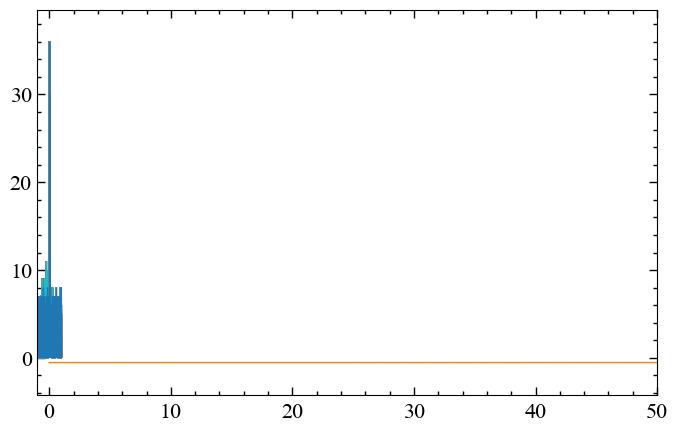

In [6]:
plt.plot(tlaggs)
plt.show()

### Final LC

In [7]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []

for i,kev in enumerate(kevArr):
    if 350<=kev<=1360:
        indexInBound.append(i)
            
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]
    
#laggApprox = -0.54

tus += avgTshift
#TODO: change bins to match the pattern from kw
asim_bins = np.round(np.arange(-1,1,0.002,dtype=np.float32),3)
hist = plt.hist(tus,bins=asim_bins,align="left",histtype="step")
asimCounts,asimEdges = hist[0],hist[1]
asimLC = LC(time=asimEdges[:-1] + binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)
kwCompare,asimCompare = CompareLC(kw_lc=kw_lc,asimShiftLC=asimLC,binsize=binsize)
CC = CrossCorrelation(kwCompare,asimCompare,mode="full")

-0.512


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


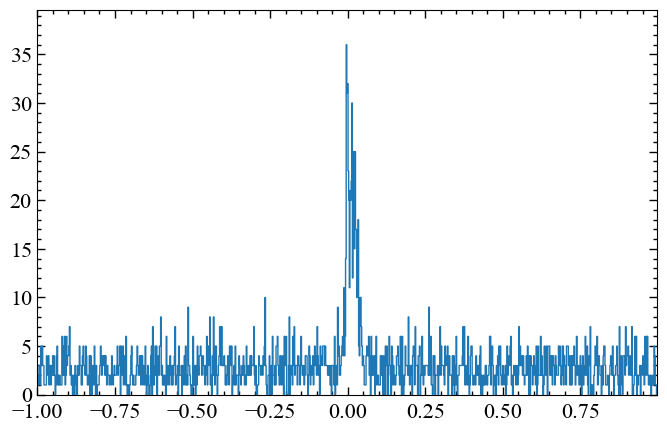

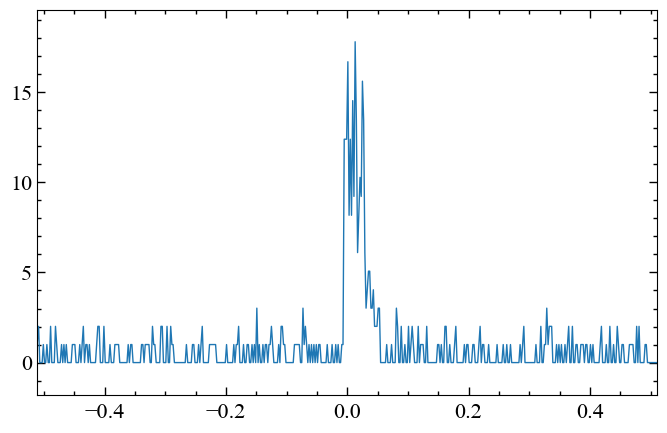

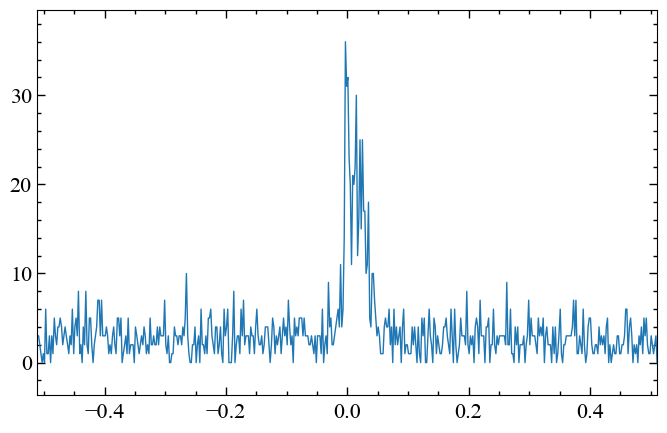

In [8]:
kwCompare.plot()
asimCompare.plot()

In [9]:
print("Total lagg (s): ", avgTshift)

Total lagg (s):  -0.5333103553921569


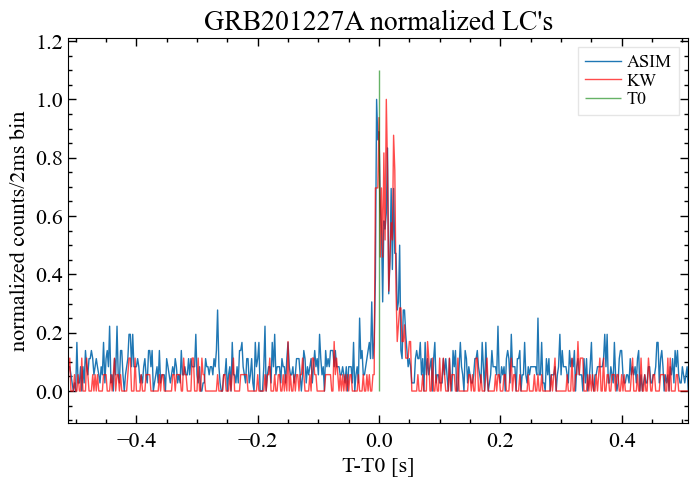

In [29]:
plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare.counts),label="ASIM")
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare.counts),c="r",alpha=0.7,label="KW")

plt.title("GRB201227A normalized LC's")
plt.xlabel("T-T0 [s]")
plt.ylabel("normalized counts/2ms bin")
plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0",alpha=0.6)
plt.legend()
#plt.savefig("/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB201227A/overlappingLC_asim.png")
plt.show()


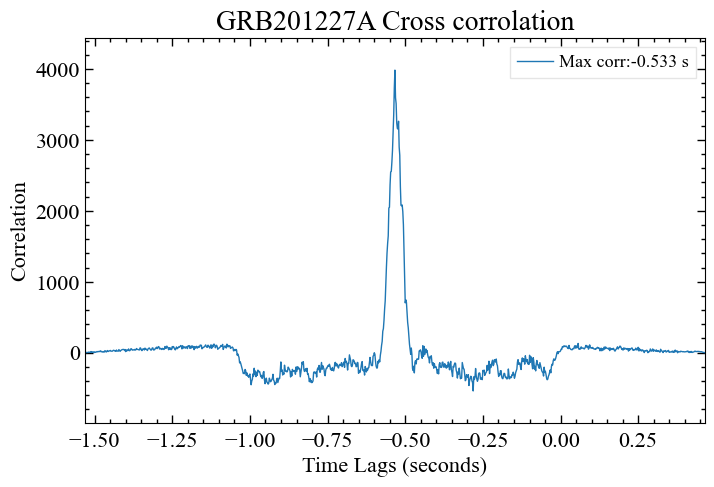

In [11]:
plt.plot(CC.time_lags+avgTshift,CC.corr,label="Max corr:-0.533 s")
plt.title("GRB201227A Cross corrolation")
plt.xlabel('Time Lags (seconds)')
plt.ylabel('Correlation')
plt.legend()
#plt.savefig("/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB201227A/CC.png")
plt.show()

ASIM_df,T0 = complete_df(grb_id="GRB201227",remove_flag=True)
T0_shift = T0 + timedelta(seconds=avgTshift)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+ avgTshift*1e6

plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=2)

keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
#All triggers in the time_interval are kept

In [12]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

keV_df

### bakground extraction 

plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

In [13]:
#From KW lc it looks like there is a precoursor that starts around T0-0.06s in the low energy band

keV_bg = keV_hist(df=ASIM_df,time_interval=(-1,-0.1),
                 keV_interval="max",
                 duration=0.9,
                 )

In [14]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')